## Introduction to the Imaging Pipeline - Day 2

Yesterday, Thinh has talked about the structure of the first half of the pipeline.

Today, I'm going to talk about how we use that existing structure to do what datajoint does best: providing you with a comprehensive and exceptionally flexible _index_ to all of your research data.

Before we go into that, though, we need to cover some fundamental database operations.

### Databases

Databases are simultaneously ubiquitous and poorly understood by many. So let's start with what a databse _is_.


---
**A database is a group of interconnected data tables**

---

That really, fundamentally, is all it is. 

A database _server_ like, say, MySQL or PostgreSQL offer lots of bells and whistles on top of that, but the main take away is that a database is a group of tables



### Interconnected tables

Interconnected means that the data in one table is related in some way to the data in another table. Why not put all that data in the _same_ table? 

Because it may not be appropriate. Consider, for example, some experimental `Event`. It has some identifying label, a date, and a subject, and a researcher:

**Sessions**

| ID | Date       | Subject | Researcher    |
|----|------------|---------|---------------|
| 1  | 2021-04-28 | Atropos | Artemis       |

This structure **enforces** that a single `Event` **shall only** have exactly one subject and one researcher. What happens if Apollo joins Artemis in running the experiment?
* We could decide that one of them was less important and only record one of them
* We can write in "Artemis/Apollo" (but this is potentially confusing when searching - e.g. alphabetic ordering will "hide" Apollo)
* We can add a column for "Researcher_2" (but what happens if I have 3 researchers?)
* We can recongise that there is a potential _one-to-many_ relationship here, which requires a different approach

**Event**

| ID | Date       | Subject |
|----|------------|---------|
| 1  | 2021-04-28 | Ananke  | 

**Event_Researchers**

| ID | Researcher |
|----|------------|
| 1  |  Artemis   |
| 1  |  Apollo    |


We might do the same thing, with a third table, if a `Event` might have multiple subjects.

Now we have two (or three!) tables that describe the same thing: a `Event`. At some future point, I need to figure out which researchers were involved in the session with `ID = 1`. How do I do that?


In [1]:
import datetime
import numpy as np
import datajoint as dj
example = dj.create_virtual_module("example", "user_simoba_example")
with dj.config(safemode=False):
    (example.Event & "id > 2").delete()

Connecting simoba@datajoint.it.ntnu.no:3306
`user_simoba_example`.`event__researcher`: 200 items
`user_simoba_example`.`event__subject`: 200 items
`user_simoba_example`.`event`: 200 items
Committed.


In [2]:
example.Event()

id,date
1,2021-04-21 00:00:00
2,2021-04-22 00:00:00


In [3]:
example.Event.Subject()

id,subject_id
1,Ananke
2,Chaos
2,Chronos


In [4]:
example.Event.Researcher()

id,researcher_id
1,Apollo
1,Artemis
2,Hera


### Joining

This is where the first important construct comes in: **joining**.

It means exactly what it says: it's a way to (temporarily) attach, or join, tables together to group the information into a single structure. In a way, it's very similar to matrix multiplication

---
Assuming that two tables share at least one column (by name), it will group like-rows together

---

In Datajoint, in both Python and Matlab, the **join** operator is represented by `*`, the same symbol used for multiplying numbers together

In [34]:
example.Event * example.Event.Researcher

id,researcher_id,date
1,Apollo,2021-04-21 00:00:00
1,Artemis,2021-04-21 00:00:00
2,Hera,2021-04-22 00:00:00


What has happened here? We joined a table with 3 rows, 2 columns (`Event`) with a table with 3 rows, 2 columns (`Event.Researcher`), toget a table with 3 rows and 3 columns

There are now 2 rows associated with `Event 1` - note the `id` and `date`, one row for each researcher. We can see the same kind of thing if we join with `Event.Subject` instead.

In [37]:
example.Event * example.Event.Subject

id,subject_id,date
1,Ananke,2021-04-21 00:00:00
2,Chaos,2021-04-22 00:00:00
2,Chronos,2021-04-22 00:00:00


What happens if we join all three tables together?

In [42]:
example.Event * example.Event.Subject * example.Event.Researcher

id,subject_id,researcher_id,date
1,Ananke,Apollo,2021-04-21 00:00:00
1,Ananke,Artemis,2021-04-21 00:00:00
2,Chaos,Hera,2021-04-22 00:00:00
2,Chronos,Hera,2021-04-22 00:00:00


This makes intuitive sense: some entries are repeated, as they have to be, but from two `Events`, each of which had _either_ 2 researchers, _or_ 2 subjects, and 1 of the other, we now have 4 rows - this is equivalent to the cross-product of two matricies

Now, what happens if we try and join two tables which don't have any columns in common?

As part of this example, I have two "lookup tables" - just lists of possible values that can be used in other tables. 

One, `Deity` is a list of major and minor Greek gods and godesses. The other, `Attribute` is a list of attributes that were at one time or another associated with one god or another. In principle, they _should_ be linked, but as far as my database is concerned, they're not. 

In [5]:
example.Deity()

name
Achlys
Aether
Aion
Ananke
Aphrodite
Apollo
Ares


In [6]:
example.Attribute()

specialisation
agriculture
art
attraction
beauty
communication
compulsion
courage


As we can see: 31 assorted deities and 59 assorted attributes. If you know any ancient Greek history, I'm sure you could link many of them up yourself. But how does the database do?

In [7]:
example.Deity * example.Attribute

name,specialisation
Achlys,agriculture
Aether,agriculture
Aion,agriculture
Ananke,agriculture
Aphrodite,agriculture
Apollo,agriculture
Ares,agriculture


1829 entries - yoiu will note that that is exactly equal to 31 * 59, and as the brief preview might hint, the effect has been to generate a _copy_ of the second table for _each_ entry in the first table. For the most part, this is a fairly useless thing to do, but it is occasionally valuable.

Mathematically, this is the Kronecker product of two matricies

### Restricting

Joining is a necessary tool to collect all the information you need together. But by itself, it's not all that useful: the point of this system is **to make it easier for you to find the information you want**

Restricting is about finding the information **that you actually want**, by defining a set of criteria. 

To make this clearer, let's add a bunch of new `Event`s to our table:

In [8]:
kwargs = {"skip_duplicates": True, "allow_direct_insert": True, "ignore_extra_fields": True}
def add_random_entries(n=200):
    entities = example.Deity.fetch("name")
    for i in range(3, n+3):
        ra = np.random.randint(0, len(entities), 2)
        entry = {
            "id": i,
            "date": datetime.datetime.now() - datetime.timedelta(
                days=np.random.randint(360),
                seconds=np.random.randint(3600)
            ),
            "subject_id": entities[ra[0]],
            "researcher_id": entities[ra[1]],
        }
        example.Event.insert1(entry, **kwargs)
        example.Event.Subject.insert1(entry, **kwargs)
        example.Event.Researcher.insert1(entry, **kwargs)
add_random_entries()

In [9]:
example.Event()

id,date
1,2021-04-21 00:00:00
2,2021-04-22 00:00:00
3,2021-03-29 14:49:46
4,2020-06-29 14:31:32
5,2020-07-16 14:46:37
6,2021-01-08 15:03:27
7,2020-06-13 15:13:20


Now we have a table with 202 Events, at random times in the previous year, with random members. It's too long a list to parse just by looking at the table on screen, so we need to work more programmatically.

Restrictions are, fundamentally, about _answering a question_. So let's consider what questions we might answer, from our toy schema here.
* How many events have, as a subject, the goddess Hera?
* How many events have, as a researcher, a deity whose name begins with "a"?
* How many Events took place after November 2020?

**Restrictions**  come in two forms:
* "Positive", that include everything matching the restriction, which uses the `&` symbol (it behaves like the `AND` operator)
* "Negative", that excludes everything matching the restriction, which ises the `-` symbol (it behaves like `AND NOT`)

First, an exact restriction by name. This is both the simplest and commonest form of restriction, where a column must take an exact value - this exact matching is shown by the use of the equals symbol `=`

In [10]:
example.Event.Subject & "subject_id = 'Hera'"

id,subject_id
18,Hera
50,Hera
83,Hera
107,Hera
135,Hera
139,Hera
202,Hera


Second, an inexact restriction, where the name must begin with the letter a.

Again, the restriction will be an equation, of sorts, written as a string. But instead of using the equals symbol, we use a keyword, `LIKE`, as in "_a_ is like _b_`

In [11]:
example.Event.Researcher & "researcher_id LIKE 'A%'"

id,researcher_id
22,Achlys
32,Achlys
75,Achlys
79,Achlys
107,Achlys
132,Achlys
135,Achlys


Two things to note here:
* Observe that the whole string is wrapped in double quotes, and the pattern that we are matching to is _also_ wrapped in single quotes. This is deliberate, as it tells the database that the kind of value we're matching to is _also_ a string
* Observe the percentage symbol. This is a _wildcard_, meaning "any number of any other characters, or none"

Thus, anything from "A" to "Az1234ghasdgasdhj" would successfully match the restriction. 

Third, restricting by date. Here, we're interested in all events _after_ a certain date, so we want something like "greater than or equals to". 

Perhaps unintuitively, we actually use "greater than", _without_ the "or equals to": since we're matching on only _part_ of the date, this is effectively the same thing.

In [12]:
example.Event & "date > '2020-11'"

id,date
1,2021-04-21 00:00:00
2,2021-04-22 00:00:00
3,2021-03-29 14:49:46
6,2021-01-08 15:03:27
8,2021-04-25 14:49:48
9,2020-12-01 14:35:34
11,2020-12-05 14:57:31


We Can use this example to showcase the engative restriction: We can rephrase "I want everything after November 2020" as "I want nothing _before_ November 2020": by swapping the `&` symbol to `-` and inverting the conditional sign, we have, functionally, the same identical query

In [13]:
example.Event - "date < '2020-11'"

id,date
1,2021-04-21 00:00:00
2,2021-04-22 00:00:00
3,2021-03-29 14:49:46
6,2021-01-08 15:03:27
8,2021-04-25 14:49:48
9,2020-12-01 14:35:34
11,2020-12-05 14:57:31


We can also chain restrictions together - for example, suppose we want all Events taking place in November _or_ December 2020. We can reuse the above restriction, and add another one

In [14]:
example.Event & "date > '2020-11'" & "date < '2021-01'"

id,date
9,2020-12-01 14:35:34
11,2020-12-05 14:57:31
18,2020-12-30 14:46:36
24,2020-11-20 14:44:13
36,2020-12-26 14:24:15
53,2020-11-06 14:53:29
61,2020-12-14 14:42:04


We can also constructu more complex logical equations to act as restrictions. I created the set of Events randomly, so there may be some where the subject and researcher have the same name. How would I find them?

In [15]:
example.Event.Subject * example.Event.Researcher & "subject_id = researcher_id"

id,subject_id,researcher_id
132,Achlys,Achlys
9,Aether,Aether
52,Apollo,Apollo
56,Artemis,Artemis
4,Dionysus,Dionysus
67,Dionysus,Dionysus
17,Eros,Eros


Note the _lack_ of single quotes inside the restriction. I don't want `subject_id` to be "researcher_id". I want both columns to have the same value

### Chaining restrictions together

The key take away from this section is that **restrictions are logical equations**. You take (or build) a big table, and then keep any rows where all the restrictions simultaneously evaluate to `True`. This means that you can use the _outcome_ of a restriction _as another restriction_. Further, by combining joins and restrictions (and parentheses), you can create extremely complex searches. 

I'm going to drop our toy example schema, and switch over to the main Imaging schema at this point, because there's no point me inventing complex examples when we have pre-made complexity all ready to go. 

In [2]:
imaging = dj.schema("group_imaging_1b")
imaging.spawn_missing_classes()
animal = dj.create_virtual_module("mlims", "prod_mlims_data")

Several arenas are described as "standard". Let's find all the sessions Horst has ever run, in any of them. We'll then save that query to a variable, because we'll use it later

In [23]:
a = (Apparatus & "apparatus_note LIKE 'standard%'")

# Horst's standard sessions:
b = Session & (Session.Apparatus & a) & "username = 'Horsto'"
b

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
8c8686481c2c0d91,0,a4380fecfaba1841,ae9cd831536bcb98,0,90647,2020-03-02 17:31:24,yes,90647-openfield1m,2Pminiscope_A,horsto
9e5afab9416b200b,0,62a1f0a4383d854a,37bab1a98514cd11,0,90218,2020-03-09 19:30:58,yes,90218-openfield1m,2Pminiscope_A,horsto
a936be26a1d73b28,0,5116e01aa80b6402,9aa26fd749530423,0,90222,2020-03-02 16:40:34,yes,90222-openfield1m,2Pminiscope_A,horsto
c2a68265c5e66ff8,0,019b32e857522ab0,9aa26fd749530423,0,90222,2020-03-08 17:34:28,yes,90222-openfield1m,2Pminiscope_A,horsto
e4093f72abec9b25,0,a4d3f5902cae47ce,37bab1a98514cd11,0,90218,2020-03-05 17:49:15,yes,90218-openfield1m,2Pminiscope_A,horsto
010817cb5e4a1ae5,0,d6ba671faad74695,78d8c2c2a38d97e2,0,60953,2020-03-06 18:07:35,yes,60953-openfield2,2Pminiscope_A,horsto
019bb8938659cfee,0,218598b321b72d27,9a5117a5c0f91e27,0,85590,2019-08-23 13:41:06,yes,85590-openfield,2Pminiscope_A,horsto


So, 335 sessions (time of writing). Where can we go from there?
* How many of those sessions have (at least one) calculated gridscore?
* How many of those sessions have (at least one) cell with a gridscore of at least 1.0?
* How many cells from Horst's standard sessions have a grid score at all?


In [28]:
b & GridScore

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
8c8686481c2c0d91,0,a4380fecfaba1841,ae9cd831536bcb98,0,90647,2020-03-02 17:31:24,yes,90647-openfield1m,2Pminiscope_A,horsto
9e5afab9416b200b,0,62a1f0a4383d854a,37bab1a98514cd11,0,90218,2020-03-09 19:30:58,yes,90218-openfield1m,2Pminiscope_A,horsto
a936be26a1d73b28,0,5116e01aa80b6402,9aa26fd749530423,0,90222,2020-03-02 16:40:34,yes,90222-openfield1m,2Pminiscope_A,horsto
c2a68265c5e66ff8,0,019b32e857522ab0,9aa26fd749530423,0,90222,2020-03-08 17:34:28,yes,90222-openfield1m,2Pminiscope_A,horsto
e4093f72abec9b25,0,a4d3f5902cae47ce,37bab1a98514cd11,0,90218,2020-03-05 17:49:15,yes,90218-openfield1m,2Pminiscope_A,horsto
010817cb5e4a1ae5,0,d6ba671faad74695,78d8c2c2a38d97e2,0,60953,2020-03-06 18:07:35,yes,60953-openfield2,2Pminiscope_A,horsto
019bb8938659cfee,0,218598b321b72d27,9a5117a5c0f91e27,0,85590,2019-08-23 13:41:06,yes,85590-openfield,2Pminiscope_A,horsto


In [88]:
b & (GridScore & "gridscore > 1")

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
8c8686481c2c0d91,0,a4380fecfaba1841,ae9cd831536bcb98,0,90647,2020-03-02 17:31:24,yes,90647-openfield1m,2Pminiscope_A,horsto
a936be26a1d73b28,0,5116e01aa80b6402,9aa26fd749530423,0,90222,2020-03-02 16:40:34,yes,90222-openfield1m,2Pminiscope_A,horsto
c2a68265c5e66ff8,0,019b32e857522ab0,9aa26fd749530423,0,90222,2020-03-08 17:34:28,yes,90222-openfield1m,2Pminiscope_A,horsto
05304a7b5f0d845a,0,5b92b96313c3fc19,ecbacf7da55524de,0,88592,2019-11-30 11:45:32,yes,88592-openfield,2Pminiscope_A,horsto
05cf1d05dcd7cf19,0,7ec3b2f8c8ee3a95,82352bc85f49963a,0,60929,2020-09-03 16:00:42,yes,60929-openfield80,2Pminiscope_A,horsto
088eaba999b6c42f,0,dbc7e204d3b73727,efb670c4cb1e73ba,0,87244,2019-08-21 15:27:13,yes,87244-openfield,2Pminiscope_A,horsto
088eaba999b6c42f,1,ef846f5b97b58189,efb670c4cb1e73ba,0,87244,2019-08-21 15:47:21,yes,87244-objectNE,2Pminiscope_A,horsto


In [89]:
GridScore & b

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",signal_dataset 16 character hash,cell_id Cell ID,channel the channel that this trace comes from (ROI masks are always primary),"spike_filter_id Parameter set ID, starting with A",tracking_dataset 16 character hash,"trackingparams_id Parameter set ID, starting with A","s_t_params_id Parameter set ID, starting with A",signal_type Signal type (Fluorescence vs. Spikes),"map_params_id Parameter set ID, starting with A","field_params_id Parameter set ID, starting with A","grid_params_id Parameter set ID, starting with A",gridscore Grid score,acorr Spatial autocorrelation
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,0,primary,A,4a71419eaa695d71,A,A,df_f,A,A,A,-0.6516838250374959,=BLOB=
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,0,primary,A,4a71419eaa695d71,A,A,df_f,B,A,A,-0.6450421596850581,=BLOB=
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,0,primary,A,4a71419eaa695d71,A,A,spikes,A,A,A,-0.3989789784341906,=BLOB=
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,0,primary,A,4a71419eaa695d71,A,A,spikes,B,A,A,-0.38124473456363894,=BLOB=
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,2,primary,A,4a71419eaa695d71,A,A,df_f,A,A,A,-0.5818078274438913,=BLOB=
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,2,primary,A,4a71419eaa695d71,A,A,df_f,B,A,A,-0.5801045378995133,=BLOB=
8c8686481c2c0d91,0,a4380fecfaba1841,69719e9bb073aa49,2,primary,A,4a71419eaa695d71,A,A,spikes,A,A,A,0.07930033516131722,=BLOB=


Compare the tables shown for the first and last questions. I've inverted the order of the equation, and gotten back completely different tables. Why? Can I even do that?

Firstly: I can do that, because _the outcome restricting a table is another table_, albeit a temporary table (i.e. it is calculated when you ask for it, it doesn't exist "on disk"). I can save that outcome, and use it as another restriction - or I can use it as a table that will be restricted further. 

All of these queries are of the form:
```
table & restriction -> restricted table
```
By inverting the order, I have changed the base table that is being restricted. Note: joining is both commutative and associative. Restricting is _neither_
```python
# commutative
table1 * table2 == table2 * table1
# associative
table1 * (table2 * table3) == (table1 * table2) * table3


table1 & restriction1 != restriction1 & table1
table1 & (table2 & restriction) != (table1 & table2) & restriction
```

`b & Gridscore` shows all members of `b` _that also appear_ (in some form) in `Gridscore`. That is - `Session` level objects that also have one (or more) gridscore objects (Cells, essentially)

`Gridscore & b` shows all members of `Gridscore` that appear in `b`.  That is - Cell level objects, that were detected during a specific set of `Session`s


### Projection

The final operation I want to note today is both the most complex, and the most powerful.

As I have already mentioned, whenever we use a Join or Restriction, the database server does the maths and gives us access to a _temporary_ table, created on the fly based on our requirements. Thus far, we have simply mixed existing tables together, to add columns, and used restrictions to remove rows. 

The point of **Projection** is that we can do something more complex than this: we can add or discard _columns_ as well. 

The very simplest way to use Projection is to rename or discard columns from a table - this is sometimes necessary where the designer of the table(s) has reused names, and that name collision causes joins to fail. Here is an example from the Imaging schema: What happens if I join together the `Session` table, with the table containing animal data from mlims?

In [3]:
Session * animal.Animal

DataJointError: Cannot join query expressions on dependent attribute `animal_name`

Short answer: an error. 

Why?

Essentially - two tables _can not_ be Joined if they both share the same _secondary_ attributes.

For convenience' sake, Horst included the `animal_name` column in `Session`. Most of the time, this makes life easier for you - you can look up sessions _directly_ via the animal name, instead of having to do an animal name to animal id lookup in the `Animal` table. However, it has the downside of complicating matters if you then need to use the `Animal` table as well.

In [30]:
Session()

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
001d0b541f48a7c6,0,001d0b541f48a7c6,0cfa0e6d25c0c601,0,60656,2019-04-11 15:31:21,no,MUnit_0,femtonics,flaviod
0034e4a1a7862daa,0,0034e4a1a7862daa,e5ec049c78d410cb,0,60584,2019-01-31 12:12:48,no,MUnit_0,femtonics,flaviod
010817cb5e4a1ae5,0,d6ba671faad74695,78d8c2c2a38d97e2,0,60953,2020-03-06 18:07:35,yes,60953-openfield2,2Pminiscope_A,horsto
0129476ffa0ff93e,0,0129476ffa0ff93e,c408ac2469c34874,0,59914,2017-10-03 11:30:00,no,MUnit_0,femtonics,flaviod
019bb8938659cfee,0,218598b321b72d27,9a5117a5c0f91e27,0,85590,2019-08-23 13:41:06,yes,85590-openfield,2Pminiscope_A,horsto
023b2455ce9e0d0a,0,7808f3752d8f5159,6779567576277cdf,0,94557,2020-10-29 18:12:37,yes,94557-imaging-20201027-1Openfield,2Pminiscope_A,weijianz
023b2455ce9e0d0a,1,69de20ab2165d126,6779567576277cdf,0,94557,2020-10-29 18:31:08,yes,94557-imaging-20201027-2Object1,2Pminiscope_A,weijianz


In [31]:
animal.Animal()

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color,animal_notes
0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
0000df481fc1421d,0,rat,20399,F,2014-08-06,Unknown,None
0001055dfb86e05d,0,mouse,95597,F,2020-06-22,Unknown,"Cull, colony reduction"
00016d089675e2f2,0,mouse,55885,M,2016-02-12,Unknown,"Cull, wrong genotype"
00033bc46ee7f5a2,0,mouse,95395,F,2020-05-30,Unknown,"Cull, colony reduction"
0003a07550faa59b,0,mouse,78224,F,2017-11-30,Unknown,"Cull, wrong genotype"
0005070177484ee2,0,rat,20259,M,2014-07-21,Unknown,None


We can solve this problem by using Projection (and indeed, it's the commonest way Projection is used)

Calling `Table.proj()` discards all secondary attributes from the table, retaining only primary attributes

In [4]:
Session * animal.Animal.proj()

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
001d0b541f48a7c6,0,001d0b541f48a7c6,0cfa0e6d25c0c601,0,60656,2019-04-11 15:31:21,no,MUnit_0,femtonics,flaviod
0034e4a1a7862daa,0,0034e4a1a7862daa,e5ec049c78d410cb,0,60584,2019-01-31 12:12:48,no,MUnit_0,femtonics,flaviod
010817cb5e4a1ae5,0,d6ba671faad74695,78d8c2c2a38d97e2,0,60953,2020-03-06 18:07:35,yes,60953-openfield2,2Pminiscope_A,horsto
0129476ffa0ff93e,0,0129476ffa0ff93e,c408ac2469c34874,0,59914,2017-10-03 11:30:00,no,MUnit_0,femtonics,flaviod
019bb8938659cfee,0,218598b321b72d27,9a5117a5c0f91e27,0,85590,2019-08-23 13:41:06,yes,85590-openfield,2Pminiscope_A,horsto
023b2455ce9e0d0a,0,7808f3752d8f5159,6779567576277cdf,0,94557,2020-10-29 18:12:37,yes,94557-imaging-20201027-1Openfield,2Pminiscope_A,weijianz
023b2455ce9e0d0a,1,69de20ab2165d126,6779567576277cdf,0,94557,2020-10-29 18:31:08,yes,94557-imaging-20201027-2Object1,2Pminiscope_A,weijianz


That kind of approach - "throw away all secondaries" is a handy go-to workaround when Joins seem to be going wrong. But there are other ways to work around it too.

Another approach is to _rename_ columns. As long as there is no overlap in the secondary column names, then the Join can proceed

In [6]:
Session * animal.Animal.proj(dob="animal_dob")

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username,dob
001d0b541f48a7c6,0,001d0b541f48a7c6,0cfa0e6d25c0c601,0,60656,2019-04-11 15:31:21,no,MUnit_0,femtonics,flaviod,2019-02-27
0034e4a1a7862daa,0,0034e4a1a7862daa,e5ec049c78d410cb,0,60584,2019-01-31 12:12:48,no,MUnit_0,femtonics,flaviod,2019-01-23
010817cb5e4a1ae5,0,d6ba671faad74695,78d8c2c2a38d97e2,0,60953,2020-03-06 18:07:35,yes,60953-openfield2,2Pminiscope_A,horsto,2019-10-03
0129476ffa0ff93e,0,0129476ffa0ff93e,c408ac2469c34874,0,59914,2017-10-03 11:30:00,no,MUnit_0,femtonics,flaviod,2017-09-01
019bb8938659cfee,0,218598b321b72d27,9a5117a5c0f91e27,0,85590,2019-08-23 13:41:06,yes,85590-openfield,2Pminiscope_A,horsto,2018-11-22
023b2455ce9e0d0a,0,7808f3752d8f5159,6779567576277cdf,0,94557,2020-10-29 18:12:37,yes,94557-imaging-20201027-1Openfield,2Pminiscope_A,weijianz,2020-03-14
023b2455ce9e0d0a,1,69de20ab2165d126,6779567576277cdf,0,94557,2020-10-29 18:31:08,yes,94557-imaging-20201027-2Object1,2Pminiscope_A,weijianz,2020-03-14


Notice the column at the end of the table, `dob`? That's the new column I "created", or rather renamed, to avoid the collision. 


Just as with the ordering of table and restriction, you need to consider what `.proj()` discards and why. If I reverse the order here, by projecting `Session` instead, we end up with something meaningless, because after removing those secondary attributes, the two tables no longer have anything in common:

In [34]:
Session.proj() * animal.Animal

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color,animal_notes
10e27fc848cc64f5,0,10e27fc848cc64f5,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
2c0f086b4bfc744b,0,2c0f086b4bfc744b,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
5395cc014e9856af,0,5395cc014e9856af,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
838ff040b09c5d7d,0,838ff040b09c5d7d,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
91023e2e4d99ff1b,0,91023e2e4d99ff1b,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
94dabdf4c9b91c4c,0,94dabdf4c9b91c4c,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"
9881d96c7d91d649,0,9881d96c7d91d649,0000da5d6810d149,0,mouse,85106,F,2018-10-07,Unknown,"Cull, wrong genotype"


Now, the more powerful use of Projection is that we can perform _computation_ with it - in much the same way that in Excel you can have columns that implement some equation based on the values in other columns. 

It's almost never _necessary_ to do so - you can do that calculation easily enough directly in Python (or Matlab). The only advantage to doing it via Projection is that it _can_ be a lot faster.

Here's an example. The `Animal` table lists the date of birth of animals, and the `DeadAnimal` table lists animals who have been noted as having died via mlims. Suppose we want to calculate the age of all living animals.

Obviously, we can do this via Python:
* Get the list of all living animals
* Fetch their dates of birth
* Subtract the DsOB from today's date


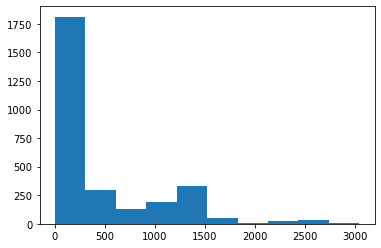

In [63]:
import datetime
import matplotlib.pyplot as plt
dob = (animal.Animal - animal.DeadAnimal).fetch("animal_dob")
now = datetime.date.today()
ages1 = [(now - d).days for d in dob if isinstance(d, datetime.date)]
_ = plt.hist(ages1)

And now via Projection

In [8]:
live_animals = (animal.Animal - animal.DeadAnimal)
known_ages = live_animals.proj(age="TIMESTAMPDIFF(DAY, animal_dob, now())")
known_ages

animal_id,datasource_id,age calculated attribute
00062843f7d3ffce,0,None
0031d811e5b621e7,0,520
0039c20b20a9130e,0,51
004925306babfdbf,0,216
00555cb6afbb277f,0,None
006e63967c11fac1,0,42
007af8ff6d882bde,0,25


In [10]:
import matplotlib.pyplot as plt

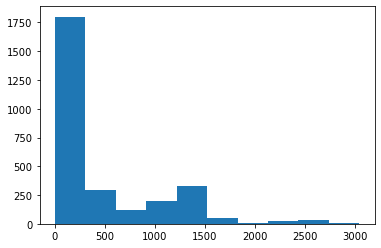

In [11]:
ages2 = (known_ages & "age IS NOT NULL").fetch("age")
_ = plt.hist(ages2)

It's a bit of a simplistic example, so there's no so much obvious difference between the two here - and the Python example may be easier to understand for future-you (which is a _very_ important characteristic of code!)

However, where the Projection approach comes in handy is if it's part of a more complex query. Constructing queries is a lot simpler if it can all stay in "database logic", and not require back and forth with processing on both your laptop and the database server. 

Consider, for instance, if we wanted to identify all sessions with a specific age-cohort of animals. That would mean comparing the session_time to the date of birth, instead of today's date, but it's the same principle. 

In the Python case, it would involve transferring a very large amount of data to your computer, running a script over it to identify the relevant animals, extracting their names or ids, and sending them back to the database server. If you have to do that several times in the course of a query, it is *considerably* slower than having it all run on the server end. 


In [35]:
import time

age_range = (180, 240)

t0 = time.time()
correct = []
tbl = Session * animal.Animal.proj(dob="animal_dob")
s_id, t_s, t_d = tbl.fetch("session_name", "timestamp", "dob")
for i in range(len(s_id)):
    age = (t_s[i].date() - t_d[i]).days
    if age_range[0] < age < age_range[1]:
        correct.append(s_id[i])

t1 = time.time()
print("Found {} entries in {:.3n}s".format(len(correct), t1-t0))

Found 235 entries in 0.0854s


In [36]:
t2 = time.time()
tbl = Session * animal.Animal.proj(dob="animal_dob")
sessions = (
        tbl.proj(animal_age="TIMESTAMPDIFF(DAY, dob, timestamp)")
        & "animal_age > {}".format(age_range[0])
        & "animal_age < {}".format(age_range[1])
    )
number = len(tbl)
t3 = time.time()
print("Found {} entries in {:.3n}s".format(number, t3-t2))

Found 950 entries in 0.0909s


## Exercises

Learning is best reinforced by _practicing_ as well as _listening_, so Horst has provided a set of exercises to demonstrate the use of these techniques - these are all tasks Horst has come across in his every day work, not just artbirary roadblocks. 

The exercises are provided as a Jupyter notebook. Have a go at those exercises (and ask for help where needed!), and then we will go through afterwards how they can be solved (and possible which of several ways are best to solve them